In [1]:
import numpy as np
import sentinel1decoder
import pandas as pd
import numpy as np
import logging
import math
import cmath
import struct
import matplotlib.pyplot as plt
from matplotlib import colors
import torch

from scipy.interpolate import interp1d

def image_focusing(eph, kernel, new_selection):

    #####################################
    ### IMAGE PROCESSING (FIRST STEP) ###
    #####################################
    print('newmetashape:', new_selection.shape)
    # Image sizes
    len_range_line = kernel.shape[1]
    len_az_line = kernel.shape[0]

    # Tx pulse parameters
    c = sentinel1decoder.constants.SPEED_OF_LIGHT_MPS
    RGDEC = new_selection["Range Decimation"].unique()[0]
    PRI = new_selection["PRI"].unique()[0]
    rank = new_selection["Rank"].unique()[0]
    suppressed_data_time = 320/(8*sentinel1decoder.constants.F_REF)
    range_start_time = new_selection["SWST"].unique()[0] + suppressed_data_time
    wavelength = sentinel1decoder.constants.TX_WAVELENGTH_M

    # Sample rates
    range_sample_freq = sentinel1decoder.utilities.range_dec_to_sample_rate(RGDEC)
    range_sample_period = 1/range_sample_freq
    az_sample_freq = 1 / PRI
    az_sample_period = PRI

    # Fast time vector - defines the time axis along the fast time direction (azimuth)
    sample_num_along_range_line = np.arange(0, len_range_line, 1)
    fast_time_vec = range_start_time + (range_sample_period * sample_num_along_range_line)

    # Slant range vector - defines R0, the range of closest approach, for each range cell
    slant_range_vec = ((rank * PRI) + fast_time_vec) * c/2
    
    costanti_rh = {'rank':rank, 'PRI':PRI, 'fast_time_vec':fast_time_vec, 'c':c, 'range_start_time': range_start_time, 'range_sample_period':range_sample_period, 'sample_num_along_range_line':sample_num_along_range_line}
    pd.to_pickle(costanti_rh, 'costanti_rh.pkl')
    
    torch.save(torch.tensor(slant_range_vec),'R0_rh.pt')
    # Axes - defines the frequency axes in each direction after FFT
    SWL = len_range_line/range_sample_freq

    #az_freq_vals = np.arange(-az_sample_freq/2, az_sample_freq/2, 1/(PRI*len_az_line))
    az_freq_vals = np.linspace(-az_sample_freq/2, az_sample_freq/2, num=len_az_line)
    range_freq_vals = np.arange(-range_sample_freq/2, range_sample_freq/2, 1/SWL)

    # Spacecraft velocity - numerical calculation of the effective spacecraft velocity
    ecef_vels = eph.apply(lambda x: math.sqrt(x["X-axis velocity ECEF"]**2 + x["Y-axis velocity ECEF"]**2 +x["Z-axis velocity ECEF"]**2), axis=1)
    velocity_interp = interp1d(eph["POD Solution Data Timestamp"].unique(), ecef_vels.unique(), fill_value="extrapolate")
    x_interp = interp1d(eph["POD Solution Data Timestamp"].unique(), eph["X-axis position ECEF"].unique(), fill_value="extrapolate")
    y_interp = interp1d(eph["POD Solution Data Timestamp"].unique(), eph["Y-axis position ECEF"].unique(), fill_value="extrapolate")
    z_interp = interp1d(eph["POD Solution Data Timestamp"].unique(), eph["Z-axis position ECEF"].unique(), fill_value="extrapolate")
    space_velocities = new_selection.apply(lambda x: velocity_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)

    # D computation
    x_positions = new_selection.apply(lambda x: x_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)
    y_positions = new_selection.apply(lambda x: y_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)
    z_positions = new_selection.apply(lambda x: z_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)

    position_array = np.transpose(np.vstack((x_positions, y_positions, z_positions)))

    a = sentinel1decoder.constants.WGS84_SEMI_MAJOR_AXIS_M
    b = sentinel1decoder.constants.WGS84_SEMI_MINOR_AXIS_M
    H = np.linalg.norm(position_array, axis=1)
    W = np.divide(space_velocities, H)
    lat = np.arctan(np.divide(position_array[:, 2], position_array[:, 0]))
    local_earth_rad = np.sqrt(
        np.divide(
            (np.square(a**2 * np.cos(lat)) + np.square(b**2 * np.sin(lat))),
            (np.square(a * np.cos(lat)) + np.square(b * np.sin(lat)))
        )
    )
    cos_beta = (np.divide(np.square(local_earth_rad) + np.square(H) - np.square(slant_range_vec[:, np.newaxis]) , 2 * local_earth_rad * H))
    ground_velocities = local_earth_rad * W * cos_beta

    effective_velocities = np.sqrt(space_velocities * ground_velocities)

    D = np.sqrt(
        1 - np.divide(
            wavelength**2 * np.square(az_freq_vals),
            4 * np.square(effective_velocities)
        )
    ).T

    torch.save(torch.tensor(D), 'D_by_richall.pt')

    # We're only interested in keeping D, so free up some memory by deleting these large arrays.
    # del effective_velocities
    del ground_velocities
    del cos_beta
    del local_earth_rad
    del H
    del W
    del lat

    ###########################################
    ### CONVERT DATA TO 2D FREQUENCY DOMAIN ###
    ###########################################
    N = len_range_line
    # FFT each range line
    radar_data = np.fft.fft(kernel, N, axis=1)

    # FFT each azimuth line
    radar_data = np.fft.fftshift(np.fft.fft(radar_data, axis=0), axes=0)

    ###########################################################
    ### RANGE COMPRESSION - CREATE AND APPLY MATCHED FILTER ###
    ###########################################################
    '''
    Range compression is relatively simple. Range information is encoded in the 
    arrival time of the pulse echo (i.e. an echo from a target further away will 
    take longer to arrive), so by applying a matched filter consisting of the 
    transmitted pulse, we can effectively focus the image along the range axis.

    We can synthesize a replica of the Tx pulse from parameters specified in 
    the packet metadata. Since we're operating in the frequency domain, we also 
    need to transform our pulse replica that we're using as a matched filter to the 
    frequency domain, then take the complex conjugate. FInally, we need to multiply 
    every range line by our matched filter.
    '''
    # Create replica pulse
    '''
    Reminder: change the selection dataset
    '''
    TXPSF = new_selection["Tx Pulse Start Frequency"].unique()[0]
    TXPRR = new_selection["Tx Ramp Rate"].unique()[0]
    TXPL = new_selection["Tx Pulse Length"].unique()[0]
    print('TXPL:',TXPL)
    print('range_sample_frequency:',range_sample_freq)
    
    
    num_tx_vals = int(TXPL*range_sample_freq)
    print('num tx vals = ', num_tx_vals)
    tx_replica_time_vals = np.linspace(-TXPL/2, TXPL/2, num=num_tx_vals)
    phi1 = TXPSF + TXPRR*TXPL/2
    phi2 = TXPRR/2
    tx_replica = np.exp(2j * np.pi * (phi1*tx_replica_time_vals + phi2*tx_replica_time_vals**2))

    old_method = False

    # Create range filter from replica pulse
    range_filter = np.zeros(len_range_line, dtype=complex)
    
    if old_method:
        index_start = np.ceil((len_range_line-num_tx_vals)/2)-1
        index_end = num_tx_vals+np.ceil((len_range_line-num_tx_vals)/2)-2
        range_filter[int(index_start):int(index_end+1)] = tx_replica
    else:
        range_filter = np.fft.fft(tx_replica, len_range_line)

    # range_filter = range_filter[0:3000]
    # range_filter = np.conjugate(np.fft.fft(range_filter))
    range_filter = np.conjugate(range_filter)

    # Apply filter
    radar_data = np.multiply(radar_data, range_filter)

    del range_filter
    del tx_replica

    #######################################
    ### RANGE CELL MIGRATION CORRECTION ###
    #######################################
    '''
    Since the collector motion couples range and azimuth information, 
    point targets will tend to produce returns spread in arcs across multiple 
    range bins as the azimuth varies. We therefore need to apply a shift to align 
    the phase history associated with each pointliradar_datake target into a single range bin, 
    so we can then operate 1-dimensionally along the azimuth axis to perform azimuth 
    compresison.
    '''
    # Create RCMC filter
    range_freq_vals = np.linspace(-range_sample_freq/2, range_sample_freq/2, num=len_range_line)
    rcmc_shift = slant_range_vec[0] * (np.divide(1, D) - 1)
    torch.save(torch.tensor(rcmc_shift), 'rcmc_shift_rh.pt')
    
    rcmc_filter = np.exp(4j * np.pi * range_freq_vals * rcmc_shift / c)
    torch.save(torch.tensor(rcmc_filter), 'filtro_rcmc_rh.pt')
    # Apply filter
    radar_data = np.multiply(radar_data, rcmc_filter)

    del rcmc_shift
    del rcmc_filter
    del range_freq_vals

    #######################################
    ### CONVERT TO RANGE-DOPPLER DOMAIN ###
    #######################################
    '''
    We've finished processing the image in range, so we can inverse FFT back to the 
    range domain along the range axis. The image will still be in the frequency domain 
    in azimuth.
    '''
    radar_data = np.fft.ifftshift(np.fft.ifft(radar_data, axis=1), axes=1)

    #############################################################
    ### AZIMUTH COMPRESSION - CREATE AND APPLY MATCHED FILTER ###
    #############################################################
    # Create filter
    az_filter = np.exp(4j * np.pi * slant_range_vec * D / wavelength)
    torch.save(torch.tensor(az_filter), 'filtro_azi_rh.pt')

    # Apply filter
    radar_data = np.multiply(radar_data, az_filter)

    del az_filter

    # TRANSFORM BACK TO RANGE-AZIMUTH DOMAIN
    radar_data = np.fft.ifft(radar_data, axis=0)

    return radar_data, effective_velocities

In [2]:
raw_path = '/media/warmachine/DBDISK/SSFocus/data/Processed/Sao_Paolo/raw_s1b-s6-raw-s-vv-20210103t214313-20210103t214344-024995-02f995.pkl'
focus_path = '/media/warmachine/DBDISK/SSFocus/data/Processed/Sao_Paolo/focused_raw_s1b-s6-raw-s-vv-20210103t214313-20210103t214344-024995-02f995.pkl'

raw = pd.read_pickle(raw_path)
focused = pd.read_pickle(focus_path)

radar_data = raw['echo']
aux = raw['metadata']
eph = raw['ephemeris']

In [9]:
loaded_submatrix = radar_data[8000:10000, 5000:10000]
selection = aux
new_selection = selection[8000:10000]

In [10]:
focus, eff_vel = image_focusing(eph, loaded_submatrix, new_selection=new_selection)

newmetashape: (2000, 41)
TXPL: 5.109935242723139e-05
range_sample_frequency: 46918402.800000004
num tx vals =  2397


In [ ]:
def are_matrices_similar(matrix1, matrix2, threshold=1e-5):
    """
    Check if two matrices have similar values within a specified threshold.

    Args:
    matrix1 (array-like): The first matrix.
    matrix2 (array-like): The second matrix.
    threshold (float): The threshold below which differences are acceptable.

    Returns:
    bool: True if matrices are similar within the threshold, False otherwise.
    """
    # First, check if the shapes of the two matrices are the same
    if matrix1.shape != matrix2.shape:
        return False

    # Check if the absolute difference between each corresponding element is within the threshold
    return (abs(matrix1 - matrix2) < threshold).all()

# Example usage:
# are_matrices_similar(np.array([[1.0, 2.0], [3.0, 4.0]]), np.array([[1.000001, 2.000001], [3.0, 4.0]]), threshold=1e-5)
# This would return True if the differences between corresponding elements are below the threshold.





In [ ]:
D_ai = torch.load('/media/warmachine/DBDISK/SSFocus/D_estimated_by_AI.pt')
D_ra = torch.load('/media/warmachine/DBDISK/SSFocus/D_by_richall.pt')

rcmc_ai = torch.load('/media/warmachine/DBDISK/SSFocus/filtro_rcmc_ai.pt')
rcmc_rh = torch.load('/media/warmachine/DBDISK/SSFocus/filtro_rcmc_rh.pt')

In [ ]:
are_matrices_similar(D_ai.cpu().numpy(), D_ra.numpy())

In [ ]:
c_ai = pd.read_pickle('/media/warmachine/DBDISK/SSFocus/costanti_ai.pkl')
c_rh = pd.read_pickle('/media/warmachine/DBDISK/SSFocus/costanti_rh.pkl')


a = c_rh['sample_num_along_range_line']
b = c_ai['sample_num_along_range_line'].numpy()
plt.plot(a-b)

rank_ai = c_ai['rank']
rank_rh = c_rh['rank']
print(rank_ai-rank_rh)

rank_ai = c_ai['PRI']
rank_rh = c_rh['PRI']
print(rank_ai-rank_rh)

rank_ai = c_ai['c']
rank_rh = c_rh['c']
print(rank_ai-rank_rh)



In [ ]:
plt.figure()
plt.plot(c_rh['fast_time_vec'] - c_ai['fast_time_vec'].cpu().numpy())

In [ ]:
R0_ai = torch.load('/media/warmachine/DBDISK/SSFocus/R0_ai.pt')
R0_rh = torch.load('/media/warmachine/DBDISK/SSFocus/R0_rh.pt')
(abs(R0_ai.cpu().numpy() - R0_rh.cpu().numpy()) < 1e-5).all()

plt.figure()
plt.plot(R0_ai.cpu().numpy()- R0_rh.cpu().numpy())

In [ ]:
shift_ai = torch.load('/media/warmachine/DBDISK/SSFocus/rcmc_shift_ai.pt')
shift_rh = torch.load('/media/warmachine/DBDISK/SSFocus/rcmc_shift_rh.pt')

(abs(shift_ai.cpu().numpy() - shift_rh.cpu().numpy()) < 1e-5).all()


In [ ]:
shift_ai

In [ ]:
shift_rh

In [ ]:
are_matrices_similar(rcmc_ai.cpu().numpy(), rcmc_rh.numpy())

In [ ]:
plt.imshow(abs(rcmc_ai.cpu().numpy()))

In [ ]:
plt.imshow(abs(rcmc_rh.numpy()))

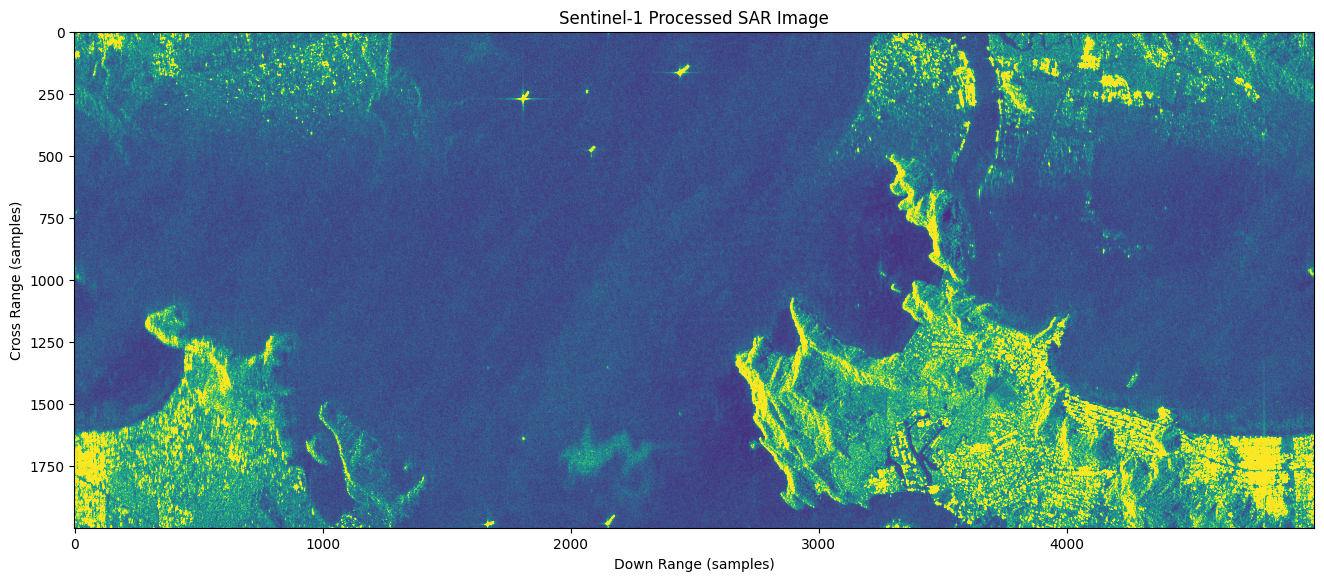

In [11]:
from matplotlib.colors import LogNorm

# Plot final image
plt.figure(figsize=(16, 16))
plt.title("Sentinel-1 Processed SAR Image")
#plt.imshow(abs(radar_data[:,:]), vmin=0, vmax=2000, origin='lower')
res = focus
k=1.2
res = np.abs(res)
plt.imshow(res, vmin=0, vmax=1000)  # vmin should be > 0 for LogNorm
plt.xlabel("Down Range (samples)")
plt.ylabel("Cross Range (samples)")
plt.show()

In [ ]:
a = eff_vel[0,0]
b = eff_vel[-1,0]

(b-a)/1000


In [ ]:
plt.plot(eff_vel[:,0])